In [1]:
import spacy
import gensim
import pandas as pd
import nltk
import numpy as np
import seaborn as sn
import re
import string
import xgboost as xgb

from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from gensim.models.fasttext import FastText
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from MeanVectorizer import MeanEmbeddingVectorizer
from sklearn.utils import resample

nlp = spacy.blank('id')
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\egapa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
df = pd.read_excel("dataset_twitter.xlsx")
df.head()

,label,komentar
0,positif,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...
1,positif,"Sharing pengalaman aja, kemarin jam 18.00 bata..."
2,positif,Sharing sama temen tuh emg guna bgt. Disaat lu...
3,positif,"sangat bersyukur bisa mendoakan kakeknya, Bung..."
4,positif,H-9. Mau ke bank rame bgt ampe antrian tempat ...


In [3]:
komentar = df['komentar'].astype(str)

# Huruf kecil
komentar = komentar.apply(lambda x: x.lower())

# Hapus URL
komentar = komentar.apply(lambda x: re.sub(r'^https?:\/\/.*[\r\n]*', '', x, flags=re.MULTILINE))

# Hapus angka
komentar = komentar.apply(lambda x: re.sub(r"\d", "", x))

# Hapus tanda baca
komentar = komentar.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Hapus diluar alphabet dan numeric
komentar = komentar.apply(lambda x: re.sub(r'([^\s\w]|_)+', '', x))

# Tokenizing data
komentar = komentar.apply(lambda x: nltk.tokenize.word_tokenize(x))

df['komentar'] = komentar
df

,label,komentar
0,positif,"[kepingin, gudeg, mbarek, bu, hj, amad, foto, ..."
1,positif,"[sharing, pengalaman, aja, kemarin, jam, batal..."
2,positif,"[sharing, sama, temen, tuh, emg, guna, bgt, di..."
3,positif,"[sangat, bersyukur, bisa, mendoakan, kakeknya,..."
4,positif,"[h, mau, ke, bank, rame, bgt, ampe, antrian, t..."
...,...,...
3110,netral,"[bukan, saya, yang, tidakmau, merit, sat, ini,..."
3111,netral,"[baru, lihat, kabar, teman, nge, gosip, dan, p..."
3112,netral,"[mengubah, kebiasaan, seseorang, yg, kurang, b..."
3113,netral,"[nah, diam, lebih, bagus, yaudah, saya, diam, ..."


In [4]:
df['label'].value_counts()

negatif    1101
positif    1017
netral      997
Name: label, dtype: int64

In [5]:
df = df[df.komentar.astype(bool)]

df_pos = df[df['label'] == 'positif']
X_pos_text = df_pos['komentar']
y_pos_label = df_pos['label']

df_neg = df[df['label'] == 'negatif']
X_neg_text = df_neg['komentar']
y_neg_label = df_neg['label']

df_net = df[df['label'] == 'netral']
X_net_text = df_net['komentar']
y_net_label = df_net['label']

In [6]:
X_pos_train, X_pos_test, y_pos_train, y_pos_test = train_test_split(X_pos_text, y_pos_label, test_size=0.2, random_state=1, stratify=y_pos_label)
X_neg_train, X_neg_test, y_neg_train, y_neg_test = train_test_split(X_neg_text, y_neg_label, test_size=0.2, random_state=1, stratify=y_neg_label)
X_net_train, X_net_test, y_net_train, y_net_test = train_test_split(X_net_text, y_net_label, test_size=0.2, random_state=1, stratify=y_net_label)

In [7]:
X_pos_train_down = resample(X_pos_train, replace=True, n_samples=int(len(X_neg_train)))
y_pos_train_down = resample(y_pos_train, replace=True, n_samples=int(len(y_neg_train)))

X_net_train_up = resample(X_net_train, replace=True, n_samples=int(len(X_neg_train)))
y_net_train_up = resample(y_net_train, replace=True, n_samples=int(len(y_neg_train)))

In [8]:
X_train = pd.concat([X_neg_train, X_pos_train_down])
X_train = pd.concat([X_train, X_net_train_up])
y_train = pd.concat([y_neg_train, y_pos_train_down])
y_train = pd.concat([y_train, y_net_train_up])

X_test = pd.concat([X_neg_test, X_pos_test])
X_test = pd.concat([X_test, X_net_test])
y_test = pd.concat([y_neg_test, y_pos_test])
y_test = pd.concat([y_test, y_net_test])

In [9]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [10]:
print(y_train.value_counts())

netral     880
positif    880
negatif    880
Name: label, dtype: int64


In [11]:
from gensim.models.fasttext import FastText
model = FastText.load_fasttext_format('../../cc.id.300.bin')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `load_fasttext_format` (use load_facebook_vectors (to use pretrained embeddings) or load_facebook_model (to continue training with the loaded full model, more RAM) instead).
  


In [12]:
mean_vec_tr = MeanEmbeddingVectorizer(model)

In [13]:
X_train_vector = mean_vec_tr.transform(X_train)
X_test_vector = mean_vec_tr.transform(X_test)

In [14]:
lc = preprocessing.LabelEncoder()
lc.fit(y_train)

LabelEncoder()

In [15]:
y_train_enc=lc.transform(y_train)
y_test_enc=lc.transform(y_test)

In [16]:
train=xgb.DMatrix(X_train_vector,label=y_train_enc)
test=xgb.DMatrix(X_test_vector,label=y_test_enc)

In [17]:
param = {}

# Learning Rate:  0.01
# Gamma:  0.5
# Max Depth:  12
# Subsample:  0.4
# Colsample Bytree:  0.3
# Alpha:  0.01
# Lamda:  2
# Min Child Weight:  3
# Number of Trees:  1000

param['num_class']=len(set(y_train))
param['objective'] = 'multi:softmax'
param['learning_rate'] = 0.01
param['gamma'] = 0.5
param['max_depth'] = 12
param['subsample'] = 0.4
param['colsample_bytree'] = 0.3
param['reg_alpha'] = 0.01
param['reg_lambda'] = 2
param['min_child_weight'] = 3
num_round = 1000

watchlist = [(train, 'train'), (test, 'test')]
bst = xgb.train(param, train, num_round, watchlist)

[0]	train-merror:0.28447	test-merror:0.57280
[1]	train-merror:0.20038	test-merror:0.53120
[2]	train-merror:0.14924	test-merror:0.51360
[3]	train-merror:0.12046	test-merror:0.48480
[4]	train-merror:0.10720	test-merror:0.46720
[5]	train-merror:0.09205	test-merror:0.46080
[6]	train-merror:0.08674	test-merror:0.43840
[7]	train-merror:0.07803	test-merror:0.44320
[8]	train-merror:0.07576	test-merror:0.44960
[9]	train-merror:0.06515	test-merror:0.44000
[10]	train-merror:0.06780	test-merror:0.43680
[11]	train-merror:0.06288	test-merror:0.45120
[12]	train-merror:0.05795	test-merror:0.44000
[13]	train-merror:0.05682	test-merror:0.44000
[14]	train-merror:0.05644	test-merror:0.43200
[15]	train-merror:0.05114	test-merror:0.43040
[16]	train-merror:0.05000	test-merror:0.43680
[17]	train-merror:0.04962	test-merror:0.43200
[18]	train-merror:0.04583	test-merror:0.43360
[19]	train-merror:0.04621	test-merror:0.42400
[20]	train-merror:0.04204	test-merror:0.43840
[21]	train-merror:0.04242	test-merror:0.4384

[177]	train-merror:0.01288	test-merror:0.39200
[178]	train-merror:0.01250	test-merror:0.39200
[179]	train-merror:0.01212	test-merror:0.39360
[180]	train-merror:0.01250	test-merror:0.39040
[181]	train-merror:0.01212	test-merror:0.39040
[182]	train-merror:0.01136	test-merror:0.39040
[183]	train-merror:0.01098	test-merror:0.38880
[184]	train-merror:0.01098	test-merror:0.38880
[185]	train-merror:0.01098	test-merror:0.39040
[186]	train-merror:0.01098	test-merror:0.39040
[187]	train-merror:0.01098	test-merror:0.39040
[188]	train-merror:0.01098	test-merror:0.38880
[189]	train-merror:0.01061	test-merror:0.38880
[190]	train-merror:0.01061	test-merror:0.38560
[191]	train-merror:0.01061	test-merror:0.38560
[192]	train-merror:0.01098	test-merror:0.38720
[193]	train-merror:0.01098	test-merror:0.38560
[194]	train-merror:0.01098	test-merror:0.38560
[195]	train-merror:0.01098	test-merror:0.38720
[196]	train-merror:0.01098	test-merror:0.38240
[197]	train-merror:0.01098	test-merror:0.38560
[198]	train-m

[352]	train-merror:0.00455	test-merror:0.39040
[353]	train-merror:0.00492	test-merror:0.39040
[354]	train-merror:0.00492	test-merror:0.39040
[355]	train-merror:0.00455	test-merror:0.38880
[356]	train-merror:0.00455	test-merror:0.39040
[357]	train-merror:0.00455	test-merror:0.38880
[358]	train-merror:0.00417	test-merror:0.38880
[359]	train-merror:0.00417	test-merror:0.38880
[360]	train-merror:0.00455	test-merror:0.38880
[361]	train-merror:0.00417	test-merror:0.39040
[362]	train-merror:0.00455	test-merror:0.38880
[363]	train-merror:0.00455	test-merror:0.38880
[364]	train-merror:0.00455	test-merror:0.38880
[365]	train-merror:0.00417	test-merror:0.38880
[366]	train-merror:0.00379	test-merror:0.38880
[367]	train-merror:0.00341	test-merror:0.38720
[368]	train-merror:0.00341	test-merror:0.38720
[369]	train-merror:0.00341	test-merror:0.38560
[370]	train-merror:0.00341	test-merror:0.38560
[371]	train-merror:0.00341	test-merror:0.38400
[372]	train-merror:0.00341	test-merror:0.38560
[373]	train-m

[527]	train-merror:0.00189	test-merror:0.38400
[528]	train-merror:0.00189	test-merror:0.38240
[529]	train-merror:0.00189	test-merror:0.38080
[530]	train-merror:0.00189	test-merror:0.38240
[531]	train-merror:0.00189	test-merror:0.38080
[532]	train-merror:0.00189	test-merror:0.38080
[533]	train-merror:0.00189	test-merror:0.37920
[534]	train-merror:0.00189	test-merror:0.37600
[535]	train-merror:0.00189	test-merror:0.37600
[536]	train-merror:0.00152	test-merror:0.37600
[537]	train-merror:0.00189	test-merror:0.37600
[538]	train-merror:0.00189	test-merror:0.38080
[539]	train-merror:0.00189	test-merror:0.37920
[540]	train-merror:0.00189	test-merror:0.37920
[541]	train-merror:0.00189	test-merror:0.37600
[542]	train-merror:0.00189	test-merror:0.37760
[543]	train-merror:0.00189	test-merror:0.37600
[544]	train-merror:0.00189	test-merror:0.37760
[545]	train-merror:0.00189	test-merror:0.37280
[546]	train-merror:0.00114	test-merror:0.37440
[547]	train-merror:0.00152	test-merror:0.37760
[548]	train-m

[702]	train-merror:0.00038	test-merror:0.36960
[703]	train-merror:0.00038	test-merror:0.36960
[704]	train-merror:0.00038	test-merror:0.36800
[705]	train-merror:0.00038	test-merror:0.36960
[706]	train-merror:0.00038	test-merror:0.36960
[707]	train-merror:0.00038	test-merror:0.36960
[708]	train-merror:0.00038	test-merror:0.36960
[709]	train-merror:0.00038	test-merror:0.36960
[710]	train-merror:0.00038	test-merror:0.36800
[711]	train-merror:0.00038	test-merror:0.36800
[712]	train-merror:0.00038	test-merror:0.36960
[713]	train-merror:0.00038	test-merror:0.36800
[714]	train-merror:0.00038	test-merror:0.36960
[715]	train-merror:0.00038	test-merror:0.36640
[716]	train-merror:0.00038	test-merror:0.36320
[717]	train-merror:0.00038	test-merror:0.36640
[718]	train-merror:0.00038	test-merror:0.36640
[719]	train-merror:0.00038	test-merror:0.36480
[720]	train-merror:0.00038	test-merror:0.36320
[721]	train-merror:0.00038	test-merror:0.36480
[722]	train-merror:0.00038	test-merror:0.36480
[723]	train-m

[877]	train-merror:0.00000	test-merror:0.36640
[878]	train-merror:0.00000	test-merror:0.36640
[879]	train-merror:0.00000	test-merror:0.36640
[880]	train-merror:0.00000	test-merror:0.36480
[881]	train-merror:0.00000	test-merror:0.36320
[882]	train-merror:0.00000	test-merror:0.36320
[883]	train-merror:0.00000	test-merror:0.36160
[884]	train-merror:0.00000	test-merror:0.36160
[885]	train-merror:0.00000	test-merror:0.36320
[886]	train-merror:0.00000	test-merror:0.36160
[887]	train-merror:0.00000	test-merror:0.36160
[888]	train-merror:0.00000	test-merror:0.36160
[889]	train-merror:0.00000	test-merror:0.36160
[890]	train-merror:0.00000	test-merror:0.36160
[891]	train-merror:0.00000	test-merror:0.36160
[892]	train-merror:0.00000	test-merror:0.36160
[893]	train-merror:0.00000	test-merror:0.36160
[894]	train-merror:0.00000	test-merror:0.36160
[895]	train-merror:0.00000	test-merror:0.36160
[896]	train-merror:0.00000	test-merror:0.36160
[897]	train-merror:0.00000	test-merror:0.36160
[898]	train-m

In [18]:
pred = bst.predict(test)
pred2 = bst.predict(train)

In [19]:
predictions = lc.inverse_transform(list(map(int,pred)))
predictions2 = lc.inverse_transform(list(map(int,pred2)))

In [20]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

test_score = accuracy_score(predictions,y_test)
train_score = accuracy_score(predictions2, y_train)

print("\nTest Score\n", test_score, "\n")
print("Train Score\n", train_score, "\n")
print("CONFUSSION MATRIX\n", confusion_matrix(y_test, predictions), "\n")
print("CLASSIFICATION REPORT\n", classification_report(y_test, predictions), "\n")


Test Score
 0.6368 

Train Score
 1.0 

CONFUSSION MATRIX
 [[182  16  23]
 [ 68  93  39]
 [ 47  34 123]] 

CLASSIFICATION REPORT
               precision    recall  f1-score   support

     negatif       0.61      0.82      0.70       221
      netral       0.65      0.47      0.54       200
     positif       0.66      0.60      0.63       204

    accuracy                           0.64       625
   macro avg       0.64      0.63      0.63       625
weighted avg       0.64      0.64      0.63       625
 



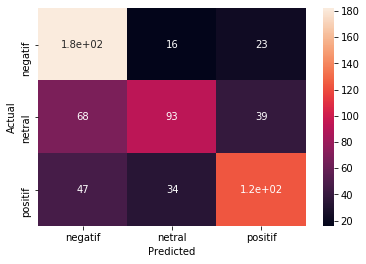

In [21]:
import seaborn as sn

confusion = pd.crosstab(y_test, predictions, rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion, annot=True)

In [22]:
# # Create XGB Classifier object
# xgb_clf = xgb.XGBClassifier(tree_method = "exact", predictor = "gpu_predictor", verbosity = 1, objective = "multi:softmax")

# # Create parameter grid
# # parameters = {"learning_rate": [0.1, 0.01, 0.001],
# #                "gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
# #                "max_depth": [2, 4, 7, 10],
# #                "colsample_bytree": [0.3, 0.6, 0.8, 1.0],
# #                "subsample": [0.2, 0.4, 0.5, 0.6, 0.7],
# #                "reg_alpha": [0, 0.5, 1],
# #                "reg_lambda": [1, 1.5, 2, 3, 4.5],
# #                "min_child_weight": [1, 3, 5, 7],
# #                "n_estimators": [100, 250, 500, 1000]}

# parameters = {"learning_rate": [0.001, 0.01, 0.1, 0.4],
#                "gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
#                "max_depth": [2, 4, 7, 10, 12],
#                "colsample_bytree": [0.3, 0.6, 0.8, 1.0],
#                "subsample": [0.2, 0.4, 0.5, 0.6, 0.7],
#                "reg_alpha": [0.001, 0.01, 0.025, 0.5, 1],
#                "reg_lambda": [1, 1.5, 2, 3, 4.5],
#                "min_child_weight": [1, 3, 5, 7],
#                "n_estimators": [100, 250, 500, 1000]}

# from sklearn.model_selection import RandomizedSearchCV
# # Create RandomizedSearchCV Object
# xgb_rscv = RandomizedSearchCV(xgb_clf, param_distributions = parameters, scoring = "f1_micro",
#                              cv = 10, verbose = 3, random_state = 40 )
           
# # Fit the model
# model_xgboost = xgb_rscv.fit(X_train_vector, y_train)

# # Model best estimators
# print("Learning Rate: ", model_xgboost.best_estimator_.get_params()["learning_rate"])
# print("Gamma: ", model_xgboost.best_estimator_.get_params()["gamma"])
# print("Max Depth: ", model_xgboost.best_estimator_.get_params()["max_depth"])
# print("Subsample: ", model_xgboost.best_estimator_.get_params()["subsample"])
# print("Colsample Bytree: ", model_xgboost.best_estimator_.get_params()["colsample_bytree"])
# print("Alpha: ", model_xgboost.best_estimator_.get_params()["reg_alpha"])
# print("Lamda: ", model_xgboost.best_estimator_.get_params()["reg_lambda"])
# print("Min Child Weight: ", model_xgboost.best_estimator_.get_params()["min_child_weight"])
# print("Number of Trees: ", model_xgboost.best_estimator_.get_params()["n_estimators"])